# Exercise 05 - Roof Classification using Transfer Learning

A common and highly effective approach to Deep Learning when using small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network
previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough (showing many different types of objects), then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual domain, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes than those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of Deep Learning compared to many older shallow learning approaches, and it makes Deep Learning very effective for small-data problems.

In this exercise, we use the ResNet50 neural network model with weights pre-prained on the ImageNet dataset, and exchange the last layer for our classification task of classifying aerial images based on the building roofs that are decipted within these images. For this purpose, the last layer(s) of the model needs to be fit to the input images, while the weights of the remaining network stays fixed.

**Learning Objectives:**

- Understand transfer learning, opportunities, and requirements
- Learn to use a pre-trained model for the classification of a reduced size dataset
- Lean how to extract specific layers from a pre-trained model
- Use the Keras Sequential API to build new models that includes parts of a pre-trained model
- Observe the training processes of two different optimizers

**Before you start, find a GPU on the system that is not heavily used by other users (with **nvidia-smi**), and change X to the id of this GPU.**

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 6

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-28 16:45:32.204811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 16:45:33.108556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:6 GPU


##  Dataset Loaders

We use the image dataset with building roofs from previous exercises, which is found and organized according to the following variables.

In [3]:
import os
from pathlib import Path

data_dir = str(Path.home()) + r'/coursematerial/GIS/dataset_img_building_roofs/'

train_dir = os.path.join(data_dir, 'train')

validation_dir = os.path.join(data_dir, 'validation')

test_dir = os.path.join(data_dir, 'test')

We again define some constants that we can use over and over instead of the direct values.

In [4]:
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

For the data generators, we use data augmentation (rotation, shift, shear, zoom, and horizontal flip) for the training data. And for all data generators, we also apply a normalization using the pre-processing function `preprocess_input()` of ResNet50, which converts the RGB images to BGR (changing the order of channels), and zero-centers the color channels with respect to the ImageNet dataset (without scaling). This function is given as argument to the `preprocessing_function` parameter.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\nData generator for training data:")

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='float32')

train_generator =  train_datagen.flow_from_directory(train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode='categorical')

print("\nData generator for validation data:")

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, dtype='float32')        

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size= BATCH_SIZE,
    class_mode='categorical')

print("\nData generator for test data:")

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, dtype='float32')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

#preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
# Preprocessing the input images makes it suitable to work with the resnet architecture.


Data generator for training data:
Found 294 images belonging to 3 classes.

Data generator for validation data:
Found 72 images belonging to 3 classes.

Data generator for test data:
Found 123 images belonging to 3 classes.


## ResNet50 based model construction

In this exercise, we will use the `ResNet50` model as provided by Keras. There are two ways to leverage a pre-trained network: 1. exchanging and training the last layer only, and 2. to also fine tune the whole network weights. We load a ResNet50 model that was pre-trained on ImageNet, and we retrain only the final (new) classification layer(s), while keeping all other layers frozen.

To the constructor of the `ResNet50` class, we pass three arguments:
- `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don’t pass it, then the network will be able to process inputs of any size. We use the input values from our above defined constants.
- `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier, we don’t need to include it and provide the value False.
- `weights`, to specify which weights to initialize the model with. It can be `None`, `imagenet` for ImageNet, or the path to weights stored somewhere from a previous training process.

In [6]:
resnet_base =tf.keras.applications.resnet.ResNet50(
    input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3),
    include_top=False,
    weights='imagenet') #Transfer learning. 

#When include_top=False, the ResNet50 model will not include the final classification layer,
#and the output will be the activations of the last convolutional layer. 
#This allows you to add your own custom layers on top of the ResNet50 base, adapting the model for your specific task.

2023-11-28 16:45:35.049966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14744 MB memory:  -> device: 6, name: Quadro RTX 5000, pci bus id: 0000:c1:00.0, compute capability: 7.5


In [7]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Next, we freeze all layers by setting the attribute `trainable` of all layers to False, so that they are not trained when fitting the model to the data. (Remember that the classification layer is not included yet.) We therefore loop through all layers of the model and set the attribute accordingly.

In [8]:
for layer in resnet_base.layers:
    layer.trainable = False

Next, we get all layer names of the ResNet50 module by looping through the layers and storing the name attributes in a list. For a short syntax, list comprehension is used. Then all layers are printed as a comma seperated string.

In [9]:
layer_names = [layer.name for layer in resnet_base.layers]

print(layer_names, sep=", ")

['input_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_bl

The name of the last layer can be retrieved at index -1.

In [10]:
layer_names[-1]

'conv5_block3_out'

Let us check what the output shape of the ResNet50 model (without the last classification layer) looks like. We can get a layer with the `get_layer()` method, and it's output shape with the `output_shape` attribute.

In [11]:
last_layer = resnet_base.get_layer(layer_names[-1])

print('Last layer output shape: ', last_layer.output_shape)

Last layer output shape:  (None, 7, 7, 2048)


Since the batch size is not yet known to the model, the first dimension shows None. Other than that, we have a 7 by 7 (2D) activation map with 2048 channels, which forms the final activation volume.

We now extend the ResNet50 base model by adding dense layers on top of it, and training the whole network end-to-end on the input data. We do this by constructing a Sequential model, where the first layer (module) is the ResNet50 base model.
- `GlobalAveragePooling2D` - Apply global average pooling on the (2D) output of the last convolutional layer in the resnet base. (It will also get transform the 3D activation map to a 1D tensor that has as many values as there were channels in the activation volume.)
- `Dense`: A dense layer with a ReLU activation (512 units - feel free to experiment with other values).
- `Dense`: Finally, a dense layer (where the number of units equals the number of output classes) with a softmax activation function.

In [12]:
from tensorflow.keras import models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,GlobalMaxPooling2D

model = models.Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


## Training

Compile the model, and then train it with RMSprop on the training data. (Feel free to adjust the number of epochs.)

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25)

Epoch 1/25


2023-11-28 16:45:37.069771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-28 16:45:40.184595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-11-28 16:45:41.367972: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f23bb6e1300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 16:45:41.368050: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-28 16:45:41.372013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 16:45:41.462799: I .

10/10 [==============================] - ETA: 0s - loss: 6.8696 - accuracy: 0.4932

2023-11-28 16:45:44.127660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 8s 406ms/step - loss: 6.8696 - accuracy: 0.4932 - val_loss: 1.4026 - val_accuracy: 0.5972
Epoch 2/25
10/10 [==============================] - 3s 294ms/step - loss: 1.3810 - accuracy: 0.5986 - val_loss: 0.5277 - val_accuracy: 0.7917
Epoch 3/25
10/10 [==============================] - 3s 301ms/step - loss: 0.7461 - accuracy: 0.7279 - val_loss: 0.3994 - val_accuracy: 0.8889
Epoch 4/25
10/10 [==============================] - 3s 301ms/step - loss: 0.8590 - accuracy: 0.6871 - val_loss: 0.6773 - val_accuracy: 0.7361
Epoch 5/25
10/10 [==============================] - 3s 297ms/step - loss: 0.7921 - accuracy: 0.7041 - val_loss: 0.2628 - val_accuracy: 0.9306
Epoch 6/25
10/10 [==============================] - 3s 299ms/step - loss: 0.7722 - accuracy: 0.7211 - val_loss: 0.2495 - val_accuracy: 0.9306
Epoch 7/25
10/10 [==============================] - 3s 300ms/step - loss: 0.6657 - accuracy: 0.7177 - val_loss: 0.1849 - val_accuracy: 0.9444
Epoch 8/25
10/10 

Evaluate the performance of the model with the test data.

In [14]:
model.evaluate(test_generator)

2023-11-28 16:46:59.889846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 323ms/step - loss: 0.4539 - accuracy: 0.8211


[0.45387548208236694, 0.8211382031440735]

Run the following cell to plot the epochs vs. accuracy.

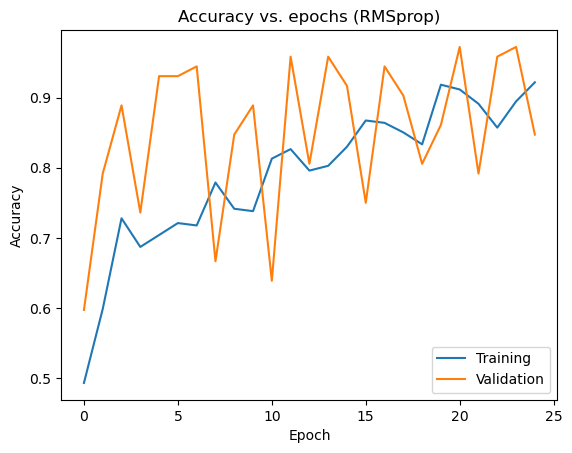

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs (RMSprop)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

And also the loss vs. epochs with the following cell.

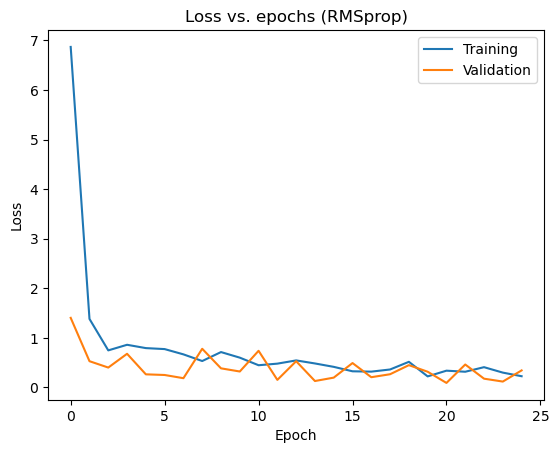

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs (RMSprop)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Now, exchange the optimizer to Adam, and train again. **But you have to make sure you construct the model anew, before you train the model, as otherwise you continue to train the model already trained by RMSprop.**

In [17]:
model = models.Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25)

Epoch 1/25


2023-11-28 16:47:02.344381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 2.6846 - accuracy: 0.5068

2023-11-28 16:47:07.636628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 6s 356ms/step - loss: 2.6846 - accuracy: 0.5068 - val_loss: 1.4191 - val_accuracy: 0.7083
Epoch 2/25
10/10 [==============================] - 3s 302ms/step - loss: 1.0209 - accuracy: 0.7143 - val_loss: 1.1513 - val_accuracy: 0.5556
Epoch 3/25
10/10 [==============================] - 3s 302ms/step - loss: 0.9081 - accuracy: 0.6497 - val_loss: 0.3944 - val_accuracy: 0.8611
Epoch 4/25
10/10 [==============================] - 3s 303ms/step - loss: 0.6276 - accuracy: 0.7755 - val_loss: 0.3306 - val_accuracy: 0.9444
Epoch 5/25
10/10 [==============================] - 3s 298ms/step - loss: 0.4905 - accuracy: 0.8129 - val_loss: 0.3791 - val_accuracy: 0.8889
Epoch 6/25
10/10 [==============================] - 3s 298ms/step - loss: 0.4399 - accuracy: 0.8265 - val_loss: 0.2465 - val_accuracy: 0.9722
Epoch 7/25
10/10 [==============================] - 3s 301ms/step - loss: 0.3485 - accuracy: 0.8776 - val_loss: 0.1951 - val_accuracy: 0.9722
Epoch 8/25
10/10 

Compare the validation accurasies from the training with RMSprop and Adam. You should see a more stable training with Adam than with RMSprop. Meaning that we do not observe as many drops in the accuracy over the epochs.

Although in the end, the test accuracy is probably the same.

In [19]:
model.evaluate(test_generator)

2023-11-28 16:48:23.359780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 135ms/step - loss: 0.4038 - accuracy: 0.8618


[0.40378889441490173, 0.8617886304855347]

Plot the accuracy vs. epoch.

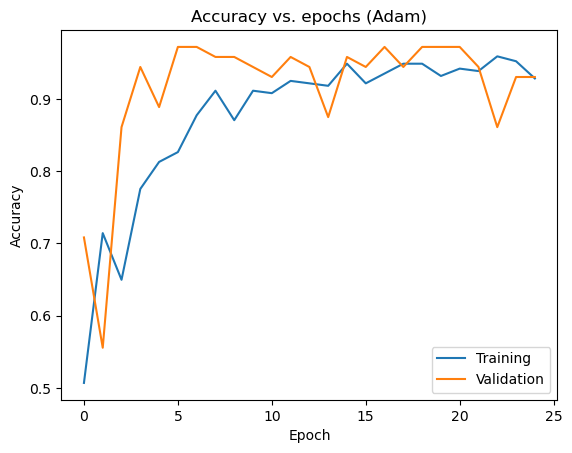

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs (Adam)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

And loss vs. epoch.

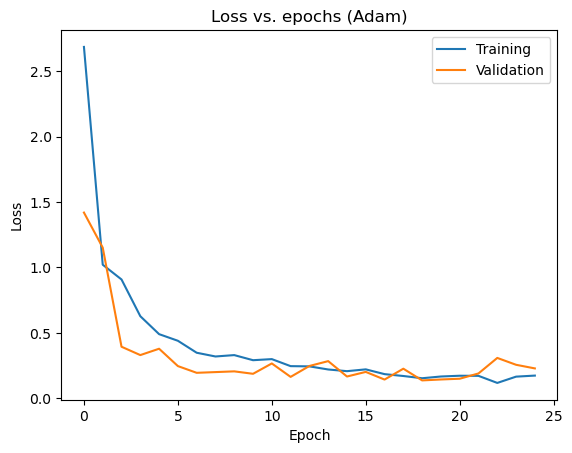

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs (Adam)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

# Prediction on images

In the end, we also want to do some predictions. But first, we take a look at an input images. For this purpose, we take from the first batch (pair of images and labels) coming from the test data generator, and then take the first image from the batch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


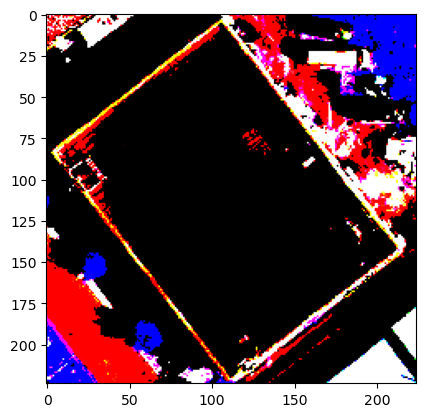

In [22]:
from keras.preprocessing import image

images, labels = test_generator[0]

_ = plt.imshow(images[0])

Because of the preprocessing, which changes the color channels, the input images look rather strange when they are output as they are. However, we ignore this and continue on.

For the image, we call the `predict()` method of the model. But we need to provide the image in a batch of at least one item. Therefore, we need to expand the image tensor to have another first dimension.

In [23]:
image = images[0]

print(image.shape)

print(tf.expand_dims(image, axis=0).shape)

class_prob = model.predict(tf.expand_dims(image, axis=0))

print(class_prob)

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 1s 888ms/step
[[0.44110692 0.20641899 0.35247403]]


Next, we take the argmax of the class probabilities, and print the index of the predicted class.

In [24]:
pred_class = tf.argmax(class_prob, axis=-1)

print("Predicted class:", pred_class.numpy())

Predicted class: [0]


And last, we get the string (key) of the class indices dictionary that the generator stored when creating the classes from the folders of input data.

In [25]:
for key, value in train_generator.class_indices.items():
    if pred_class.numpy() == value:
        print(key) 

flat_roof


In [30]:
import numpy as np

class_probs = model.predict(images)
class_indices = np.argmax(class_probs, axis=-1)

correct_predictions = 0

# Loop through each predicted and actual label pair
for pred, actual in zip(class_indices,labels):
    # Check if the predicted label matches the actual label
    if np.any(pred == actual):
        correct_predictions += 1
    # Print the predicted and actual labels
   # print(f'y_pred: {pred}, y_test: {actual}')

# Calculate accuracy
accuracy = correct_predictions / len(labels) * 100
print(f'Accuracy: {accuracy:.2f}%')

1/1 [==============================] - 0s 32ms/step
Accuracy: 81.25%


In [58]:
# Using functional API

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,GlobalMaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


# Assuming input images with dimensions (height, width, channels)
IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS = 224,224,3  #trying to see if its works for flexible inputs size
BATCH_SIZE =32

print("\nData generator for training data:")


train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='float32')

train_generator =  train_datagen.flow_from_directory(train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode='categorical')

print("\nData generator for validation data:")

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, dtype='float32')        

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size= BATCH_SIZE,
    class_mode='categorical')

print("\nData generator for test data:")

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, dtype='float32')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

#preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
# Preprocessing the input images makes it suitable to work with the resnet architecture.

# Define the ResNet50 base model
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS),
)
# Prevent the layers of the ResNet50 base architecture from updating it weights 
resnet_base.trainable = False

# Define the input tensor
input_tensor = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))

# Connect the layers using the Functional API
x = resnet_base(input_tensor)
x = GlobalMaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_tensor = layers.Dense(3, activation='softmax')(x)

# Create the model
model = models.Model(inputs=input_tensor, outputs=output_tensor)

# Display the model summary
model.summary()

# Compile the model (adjust the optimizer, loss, and metrics based on your task)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25)

model.evaluate(test_generator)

# Model used against the test_generator.
images, labels = test_generator[1]

class_probs = model.predict(images)
class_indices = np.argmax(class_probs, axis=-1)

correct_predictions = 0

# Loop through each predicted and actual label pair
for pred, actual in zip(class_indices,labels):
    # Check if the predicted label matches the actual label
    if np.any(pred == actual):
        correct_predictions += 1
    # Print the predicted and actual labels
   # print(f'y_pred: {pred}, y_test: {actual}')

# Calculate accuracy
accuracy = correct_predictions / len(labels) * 100
print(f'Accuracy: {accuracy:.2f}%')


Data generator for training data:
Found 294 images belonging to 3 classes.

Data generator for validation data:
Found 72 images belonging to 3 classes.

Data generator for test data:
Found 123 images belonging to 3 classes.
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_26 (Gl  (None, 2048)             0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_26 (Flatten)        (None, 2048)              0         
                                                                 
 dense_55 (Dense)            (N

2023-11-28 20:15:37.164523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 14.1565 - accuracy: 0.4490

2023-11-28 20:15:42.269978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 7s 433ms/step - loss: 14.1565 - accuracy: 0.4490 - val_loss: 2.3314 - val_accuracy: 0.6667
Epoch 2/25
10/10 [==============================] - 3s 300ms/step - loss: 3.5884 - accuracy: 0.5680 - val_loss: 1.3526 - val_accuracy: 0.6667
Epoch 3/25
10/10 [==============================] - 3s 297ms/step - loss: 2.1360 - accuracy: 0.6531 - val_loss: 0.5485 - val_accuracy: 0.7639
Epoch 4/25
10/10 [==============================] - 3s 302ms/step - loss: 1.2109 - accuracy: 0.6769 - val_loss: 0.6542 - val_accuracy: 0.7222
Epoch 5/25
10/10 [==============================] - 3s 314ms/step - loss: 0.9698 - accuracy: 0.6769 - val_loss: 0.7156 - val_accuracy: 0.7222
Epoch 6/25
10/10 [==============================] - 3s 328ms/step - loss: 0.6882 - accuracy: 0.6939 - val_loss: 0.7089 - val_accuracy: 0.7222
Epoch 7/25
10/10 [==============================] - 3s 329ms/step - loss: 0.6091 - accuracy: 0.7687 - val_loss: 0.5847 - val_accuracy: 0.7361
Epoch 8/25
10/10

2023-11-28 20:16:58.610421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 648ms/step
Accuracy: 93.75%
